# Prediction of Five Droplets¶
- Condition
    - paraffin: 20
    - ES volume: 10
    - n_droplets: 5
    - Dye conc.: 0.005
    - SDS conc.: 18
    - Solution volume: 30
    - Temp.: 25

In [46]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import transforms
from torchinfo import summary # ニューラルネットワークの中身を見る

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
import random

from callback import earlystopping

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 10

# シードを固定するための関数
def torch_fix_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

torch_fix_seed(seed)

In [2]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=df.shape[1], axis=1)
    return df

df = mk_dataframe("230928/pos-1.dat")

In [3]:
df

,1,2,3,4,5,6,7,8,9,10
0,-19.487352,-20.983921,12.094107,-20.311554,-21.267623,6.581969,27.602660,6.426266,-5.860874,20.263934
1,-19.477692,-20.990609,12.076036,-20.370901,-21.282763,6.608103,27.633166,6.468523,-5.852389,20.298919
2,-19.468193,-20.969928,12.033649,-20.432632,-21.242062,6.536392,27.676673,6.496846,-5.846391,20.332609
3,-19.485339,-20.993084,12.012297,-20.469834,-21.239228,6.492203,27.683456,6.516117,-5.805820,20.389551
4,-19.456484,-20.967306,11.964088,-20.512705,-21.231467,6.465272,27.695220,6.550860,-5.828000,20.450907
...,...,...,...,...,...,...,...,...,...,...
35995,-26.686792,-10.712931,11.664019,-26.336038,-17.089904,14.638866,29.112041,4.376062,10.706441,27.096429
35996,-26.682902,-10.701361,11.686294,-26.327128,-17.080562,14.621319,29.125685,4.363127,10.689143,27.113319
35997,-26.701461,-10.684797,11.651566,-26.280094,-17.088898,14.630824,29.129395,4.344246,10.711775,27.113191
35998,-26.685257,-10.696049,11.661247,-26.283274,-17.079077,14.639209,29.121010,4.383818,10.723651,27.117907


In [4]:
df_ = df.values

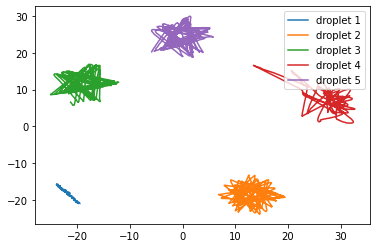

In [10]:
for i in range(int(df_.shape[-1] / 2)):
    x = i*2
    plt.plot(df_[:10000:10, x], df_[:10000:10, x+1], label="droplet {}".format(i+1))
    
plt.legend(loc="upper right")

In [18]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

# 1度arrayを1列にしてから正規化
df_scaled = scaler.fit_transform(df_.reshape(-1, 1))

In [19]:
df_scaled = df_scaled.reshape(-1, df.shape[-1])

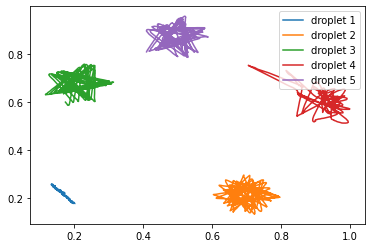

In [20]:
for i in range(int(df_.shape[-1] / 2)):
    x = i*2
    plt.plot(df_scaled[:10000:10, x], df_scaled[:10000:10, x+1], label="droplet {}".format(i+1))
    
plt.legend(loc="upper right")

## データ分割
1秒ごとのデータを1000個

In [21]:
data = df_scaled[:10000:10]

train_size = int(len(data) * 0.7)
test_size = len(data) - train_size

print("train size: {}, test size:{}".format(train_size, test_size))

train size: 700, test size:300


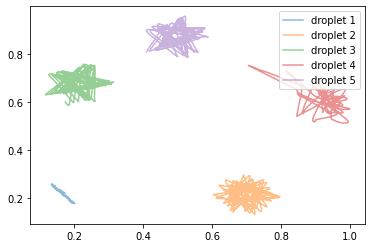

In [26]:
for i in range(int(df_.shape[-1] / 2)):
    x = i*2
    plt.plot(data[:, x], data[:, x+1], label="droplet {}".format(i+1), alpha=0.5)
    
plt.legend(loc="upper right")

In [28]:
# 何個のデータを用いて次の時刻を予測
time_step = 50
n_sample = train_size - time_step - 1

#シーケンシャルデータを格納する箱を用意(入力)
input_data = np.zeros((n_sample, time_step, 4))
#シーケンシャルデータを格納する箱を用意(正解)
correct_input_data = np.zeros((n_sample, 4))

print(input_data.shape)
print(correct_input_data.shape)

(649, 50, 4)
(649, 4)


In [29]:
# -----データローダ-----
input_data = torch.tensor(input_data, dtype=torch.float) #Tensor化(入力)
correct_data = torch.tensor(correct_input_data, dtype=torch.float) #Tensor化(正解)

dataset = torch.utils.data.TensorDataset(input_data, correct_data) #データセット作成

n_sample_train = len(dataset)
n_train = int(n_sample * 0.8)
n_val = n_sample_train - n_train

print("n_train:{}, n_val:{}".format(n_train, n_val))

train_dataset, val_dataset = torch.utils.data.random_split(dataset,
                                                           [n_train, n_val], 
                                                           generator=torch.Generator().manual_seed(seed))

# ------データローダの再現性担保-----
def seed_worker(worker_id):
    worker_seed = torch.initial_seed()

    # Seed other libraries with torch's seed
    random.seed(worker_seed)

    # Numpy seed must be between 0 and 2**32 - 1
    if worker_seed >= 2 ** 32:
        worker_seed = worker_seed % 2 ** 32
    np.random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(seed)
# -------------------------------


# datasetからバッチごとに取り出す
train_loader = DataLoader(
                            train_dataset,
                            batch_size=4,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g,
                        )

val_loader = DataLoader(
                            val_dataset,
                            batch_size=4,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g,
                        )

n_train:519, n_val:130


In [31]:
class GRU(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_layers):
        super(GRU, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        y_gru, h = self.gru(x, None)
        y = self.fc(y_gru[:, -1, :])
        
        return y

## 学習

In [41]:
def train_func(net, epoch=100):
    loss_func = nn.MSELoss(reduction="mean")

    optimizer = optim.Adam(net.parameters(), lr=0.001)

    device = torch.device("cuda:0" if torch.cuda. is_available() else "cpu")  #デバイス(GPU or CPU)設定 
    
    hist = {"train_loss":[], 
            "val_loss":[]}

    epochs = 100 #エポック数

    net.to(device)

    es = earlystopping.EarlyStopping(patience=5, verbose=1)

    for i in range(epochs):
        net.train()
        running_loss = 0.0
        running_val_loss = 0.0

        for j, (x, t) in enumerate(train_loader):
            x = x.to(device)
            optimizer.zero_grad()

            y = net(x)
            y = y.to(device)

            loss = loss_func(y, t)
            loss.backward()

            optimizer.step()
            running_loss += loss.item()

        running_loss /= j + 1
        hist["train_loss"].append(running_loss)
        
        for j, (x, t) in enumerate(val_loader):
            x, t = x.to(device), t.to(device)
            
            net.eval()
            
            pred = net(x)
            loss = loss_func(pred, t)
            running_val_loss += loss.item()
            
        running_val_loss /= j + 1
        hist["val_loss"].append(running_val_loss)


        if i%5 == 0 or i==epochs-1:
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))

        if es(running_val_loss):
            print("Epoch:{}, Train_Loss:{:3f}, Val_Loss:{:3f}".format(i, running_loss, running_val_loss))
            break
    
    #lossの推移を確認
    plt.plot(range(len(hist["train_loss"])), hist["train_loss"], label='train loss')
    plt.plot(range(len(hist["val_loss"])), hist["val_loss"], label='val loss')
    
    plt.legend()
    plt.title("Change of Loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

In [34]:
[[None for i in range(2)] for i in range(5)]

[[None, None], [None, None], [None, None], [None, None], [None, None]]

## 予測用関数

In [44]:
def future_prediction(net, data):
    X = data
    net.eval()

    gen = [[None for i in range(data.shape[-1])] for i in range(train_size)] # 予測値を時系列で保持するためのリスト

    z = X[train_size:train_size+time_step].reshape(-1, time_step, data.shape[-1]) # 予測用に未知の部分の最初time_step個

    for i in range(test_size):
        z_ = torch.Tensor(z[-1:, :])

        preds = net(z_).data.cpu().numpy()
        z = np.concatenate([z, preds.reshape(-1, 1, data.shape[-1])], 1)
        z = z[:,1:,:]
        
        for j in range(data.shape[-1]):
            gen.append([preds[0,j]])
        
    print(net)
    
    fig = plt.figure(figsize=(7,7))
    
    for i in range(int(data.shape[-1] / 2)):
        x = i*2
        plt.plot(data[:, x], data[:, x+1], label="droplet {}".format(i+1), alpha=0.5)
        
    # plt.plot(X[:train_size,0], X[:train_size,1], label="train data", color="green")
    # plt.plot(X[:train_size,2], X[:train_size,3], color="green")

    gen = np.array(gen)
    
    for i in range(int(data.shape[-1] / 2)):
        x = i * 2
        plt.plot(gen[:,x], gen[:,x+1], color="green", label="Predict")
    # plt.plot(gen[:,0], gen[:,1],label='Predicted 1')
    # plt.plot(gen[:,2], gen[:,3],label='Predicted 2')
    plt.legend()

#     plt.scatter(X[train_size+time_step,0], X[train_size+time_step,1], marker="x")
#     plt.scatter(X[train_size+time_step,2], X[train_size+time_step,3], marker="x")
    plt.title("hidden_dim={}".format(net.hidden_dim))
    
    # plt.savefig("output/spiral_hidden{}.png".format(net.hidden_dim))
    plt.show()

## Define Model

In [42]:
input_dim = 4
output_dim = 4
hidden_dim = 64
n_layers = 1

net = GRU(input_dim, output_dim, hidden_dim, n_layers)

batch_size = 4
summary(net, (batch_size, time_step, 4))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [4, 4]                    --
├─GRU: 1-1                               [4, 50, 64]               13,440
├─Linear: 1-2                            [4, 4]                    260
Total params: 13,700
Trainable params: 13,700
Non-trainable params: 0
Total mult-adds (M): 2.69
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.05
Estimated Total Size (MB): 0.16

Epoch:0, Train_Loss:0.000238, Val_Loss:0.000000
Epoch:5, Train_Loss:0.000000, Val_Loss:0.000000
early stopping
Epoch:8, Train_Loss:0.000000, Val_Loss:0.000000


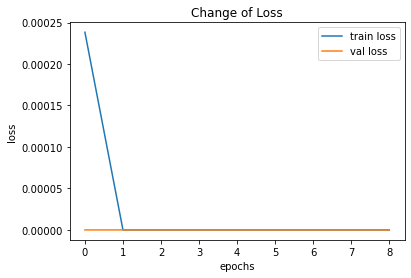

In [43]:
train_func(net, data)

In [45]:
future_prediction(net, data)

RuntimeError: input.size(-1) must be equal to input_size. Expected 4, got 10